04-victimisation-based-mechanism.ipynb
======================

**Things to do**
* Test the results.
* Generate mapping tables automatically multiple times.
* Find the number of unique cheaters who harmed other players severely.

**Sample match ID for testing**
* 000213be-6b3b-438a-8d20-c1b57b01a174 (no cheater)
* 001f0702-0bd8-4df5-8605-1258082b609d (one cheater)
* 05c04ee8-6c76-4b0d-99ed-ae44275b6612 (two cheaters)
* 3835b5e8-5b23-47a0-b60e-a37c3ac7ce74 (three cheaters)

## Load packages and read tables.

In [1]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pubg_analysis as pubg

In [2]:
# Read a table that contains edges.
td = spark.read.parquet("s3://jinny-capstone-data-test/data_for_vic_mech.parquet")
td.registerTempTable("td")

# Read a table that contains player data.
players = spark.read.parquet("s3://jinny-capstone-data-test/nodes.parquet")
players.registerTempTable("nodes")

In [3]:
# Show the first few rows of each dataset.
td.show(5)
players.show(5)

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|000ec388-a3d7-422...|account.c84796ba7...|    NA|       0|account.5028c61d0...|    NA|       0|2019-03-03 16:14:...|2019-03-03|
|000ec388-a3d7-422...|account.cba82f51c...|    NA|       0|account.b347ea78f...|    NA|       0|2019-03-03 16:33:...|2019-03-03|
|000ec388-a3d7-422...|account.8f011f0fd...|    NA|       0|account.e2f45b350...|    NA|       0|2019-03-03 16:16:...|2019-03-03|
|000ec388-a3d7-422...|account.73324618c...|    NA|       0|account.7911e1c3d...|    NA|       0|2019-03-03 16:12:...|2019-03-03|
|000ec388-a3d7-422...|account.ba7ff30f8...|    NA|       0|account.4e93215ae...|    NA|       0|2

## 1. Count the number of motifs on the empirical network.

In [3]:
res_tab = pubg.add_level_of_harm(td, 30)
res_tab.show(5)
res_tab.registerTempTable("new_td")

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|0000d4aa-07fb-4b3...|account.1866a3c61...|    NA|       0|account.cd31e8ad9...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.528ab8eb6...|    NA|       0|account.e5e3583f7...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.bdea579b5...|    NA|       0|account.695c4609e...|    NA|       0|2019-03-03 15:57:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.695c4609e...|    NA|       0|account.16c355b96...|    NA|       0|2019-03-03 15:56:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.695c4609e...|    N

In [4]:
# First, add information of killers.
src_info = spark.sql("""SELECT mid, src, start_date AS src_sd, src_bd, src_flag, 
                        dst, dst_bd, dst_flag, time, m_date, damage 
                        FROM new_td t JOIN nodes n ON t.src = n.id""")
src_info.registerTempTable("src_info")

# Add information of victims.
full_info = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag, 
                         dst, start_date AS dst_sd, dst_bd, dst_flag, time, m_date, damage 
                         FROM src_info s JOIN nodes n ON s.dst = n.id""")
full_info.registerTempTable("full_info")
full_info.show(5)

+--------------------+--------------------+------+------+--------+--------------------+------+------+--------+--------------------+----------+------+
|                 mid|                 src|src_sd|src_bd|src_flag|                 dst|dst_sd|dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+------+------+--------+--------------------+------+------+--------+--------------------+----------+------+
|297788d0-ef37-4ab...|account.50a01d43a...|    NA|    NA|       0|account.001017dce...|    NA|    NA|       0|2019-03-02 07:29:...|2019-03-02|     0|
|fcaf8c76-4e7a-4b9...|account.75f15a397...|    NA|    NA|       0|account.001017dce...|    NA|    NA|       0|2019-03-02 06:56:...|2019-03-02|     0|
|d7b4a476-007b-4e7...|account.ff01e3c0d...|    NA|    NA|       0|account.0017aeb1b...|    NA|    NA|       0|2019-03-01 08:35:...|2019-03-01|     0|
|d8324042-12e1-401...|account.ed7ea3157...|    NA|    NA|       0|account.00399d4c2...|    NA|    NA

In [5]:
legit_cases = spark.sql("SELECT * FROM full_info WHERE dst_sd != 'NA' AND src_flag == 1 AND dst_flag == 1 AND m_date >= src_sd AND m_date < dst_sd")
legit_cases.registerTempTable("legit_cases")
legit_cases.show(20)    

+--------------------+--------------------+----------+----------+--------+--------------------+----------+----------+--------+--------------------+----------+------+
|                 mid|                 src|    src_sd|    src_bd|src_flag|                 dst|    dst_sd|    dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+----------+----------+--------+--------------------+----------+----------+--------+--------------------+----------+------+
|b7f8f82b-a249-43a...|account.568c81024...|2019-03-01|2019-03-02|       1|account.e493e8036...|2019-03-02|2019-03-03|       1|2019-03-01 19:50:...|2019-03-01|     0|
|d618a666-95ef-48c...|account.8ec434ba5...|2019-03-01|2019-03-02|       1|account.e493e8036...|2019-03-02|2019-03-03|       1|2019-03-01 20:03:...|2019-03-01|     0|
|3bbb6a7e-25d1-409...|account.9ee4ebb79...|2019-03-01|2019-03-03|       1|account.d30a1abaf...|2019-03-02|2019-03-03|       1|2019-03-01 20:50:...|2019-03-01|     0|
|407

In [6]:
# Create a summary table.
victims_tab = spark.sql("""SELECT dst AS id, 
                           TO_DATE(CAST(UNIX_TIMESTAMP(dst_sd, 'yyyy-MM-dd') AS TIMESTAMP)) AS start_date, 
                           TO_DATE(CAST(UNIX_TIMESTAMP(m_date, 'yyyy-MM-dd') AS TIMESTAMP)) AS m_date, 
                           CAST(DATEDIFF(dst_sd, m_date) AS INT) AS period, src AS killer, 
                           COUNT(*) AS exp, SUM(damage) AS sev_exp FROM legit_cases
                           GROUP BY dst, dst_sd, m_date, src""")
victims_tab.registerTempTable("victims_tab")
victims_tab.show()

# Get the date when the player was first killed by cheating.
first_m_dates = spark.sql("""SELECT * 
                             FROM (SELECT id, m_date, period, ROW_NUMBER() OVER (PARTITION BY id ORDER BY m_date) 
                             AS rownumber FROM victims_tab) WHERE rownumber IN (1)""")
first_m_dates.registerTempTable("first_m_dates")

+--------------------+----------+----------+------+--------------------+---+-------+
|                  id|start_date|    m_date|period|              killer|exp|sev_exp|
+--------------------+----------+----------+------+--------------------+---+-------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|account.568c81024...|  1|      0|
|account.e493e8036...|2019-03-02|2019-03-01|     1|account.8ec434ba5...|  1|      0|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|account.9ee4ebb79...|  1|      0|
|account.53db3bd71...|2019-03-02|2019-03-01|     1|account.dddcd0225...|  1|      0|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|account.00a68dddf...|  1|      1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|account.1baf22d18...|  1|      0|
|account.272b33c63...|2019-03-02|2019-03-01|     1|account.178b7a53b...|  1|      0|
|account.476ee023d...|2019-03-02|2019-03-01|     1|account.b6c7745db...|  1|      0|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|account.cb2db1

In [7]:
# Get the table that contains the total number of victimisation experiences and the number of unique cheaters.
vic_info = spark.sql("""SELECT id, start_date, SUM(exp) AS total_exp, SUM(sev_exp) AS total_sev_exp, 
                        COUNT(DISTINCT killer) AS uniq_killers 
                        FROM victims_tab GROUP BY id, start_date""")
vic_info.registerTempTable("vic_info")
vic_info.show(5)

+--------------------+----------+---------+-------------+------------+
|                  id|start_date|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+---------+-------------+------------+
|account.d2cb5110d...|2019-03-03|        1|            0|           1|
|account.e493e8036...|2019-03-02|        2|            0|           2|
|account.52adde8ad...|2019-03-02|        1|            0|           1|
|account.53db3bd71...|2019-03-02|        1|            0|           1|
|account.6825517dd...|2019-03-02|        3|            0|           2|
+--------------------+----------+---------+-------------+------------+
only showing top 5 rows



In [8]:
add_dates = spark.sql("""SELECT v.id, v.start_date, f.m_date, f.period, 
                         v.total_exp, v.total_sev_exp, v.uniq_killers 
                         FROM vic_info v LEFT JOIN first_m_dates f ON v.id = f.id""")
add_dates.show()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.53db3bd71...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.476ee023d...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...

In [9]:
# Store the summary table in the S3 bucket for the later use.
add_dates.write.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/vic_tab.parquet")

In [10]:
vic_info_df = add_dates.toPandas()
vic_info_df.to_csv('vic_info_df.csv')

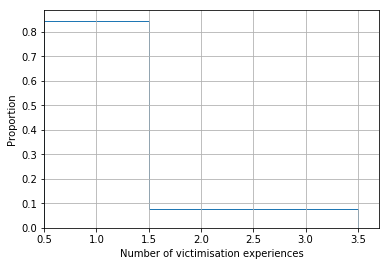

In [21]:
# Plot the distribution of the total number of victimisation experiences.
# Show the distribution of the number of contacts with cheaters before the transition happened.
# In this case, we allow duplicate pairs of killer and victim 
# as there are some victims who have been killed by the same killer more than once. 
bins = np.arange(0, vic_info_df['total_exp'].max() + 1.5) - 0.5
fig = vic_info_df.hist(column = 'total_exp', histtype='step', bins = bins, 
                       weights=np.zeros_like(vic_info_df['total_exp'])+1./len(vic_info_df['total_exp']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of victimisation experiences")
plt.ylabel("Proportion")
plt.title("")
plt.show()

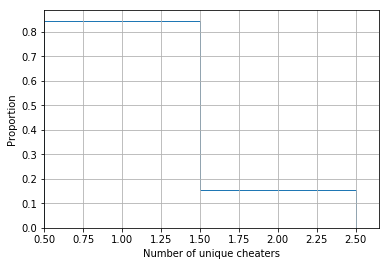

In [25]:
# Plot the distribution of the number of unique cheaters.
# In this case, we consider only unique pairs of killer and victim.
bins = np.arange(0, vic_info_df['uniq_killers'].max() + 1.5) - 0.5
fig = vic_info_df.hist(column='uniq_killers', histtype='step', bins=bins, 
                       weights=np.zeros_like(vic_info_df['uniq_killers'])+1./len(vic_info_df['uniq_killers']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of unique cheaters")
plt.ylabel("Proportion")
plt.title("")
plt.show()

## 2. Count the number of times the motif appears in the empirical network considering the level of harm caused by cheating.

In [6]:
# Count the number of motifs on the empirical network considering the level of harm.
res_tab_with_harm = pubg.get_cases_with_severe_harm(full_info, legit_cases, 30)
res_tab_with_harm.show()
res_tab_with_harm.registerTempTable("res_tab_with_harm")

4
+--------------------+--------------------+--------------------+--------------------+------+------+
|                 mid|                 src|                 dst|                time|period|damage|
+--------------------+--------------------+--------------------+--------------------+------+------+
|05b5cfc8-831d-455...|account.178b7a53b...|account.272b33c63...|2019-03-01 15:25:...|   1.0|     0|
|3bbb6a7e-25d1-409...|account.9ee4ebb79...|account.d30a1abaf...|2019-03-01 20:50:...|   1.0|     0|
|e1b0b5f5-fcda-4f4...|account.c0c6a61fe...|account.3a5102f8e...|2019-03-01 05:13:...|   1.0|     1|
|e3394f02-0d96-410...|account.4c2ff8d26...|account.6825517dd...|2019-03-01 19:04:...|   1.0|     0|
|407d731f-2e4e-4e7...|account.dddcd0225...|account.53db3bd71...|2019-03-01 23:58:...|   1.0|     0|
|b5f5e4ab-8ad5-44d...|account.de16e11d0...|account.ad074fb0c...|2019-03-01 23:45:...|   1.0|     1|
|f835a716-3076-445...|account.63d67b1ac...|account.c3d862798...|2019-03-01 06:49:...|   1.0|     0

## 2. Plot the distribution of transition period.

In [17]:
# Calculate the time difference between the first victimisation experience and start date for each cheater.
temp_tab = spark.sql("SELECT * FROM legit_cases WHERE damage = 1 ORDER BY time")
temp_tab.registerTempTable("temp_tab")
first_vic_exp = spark.sql("""SELECT * FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY dst ORDER BY time) 
                             AS rownumber FROM temp_tab) AS first_vic_exp WHERE rownumber IN (1)""")
first_vic_exp.registerTempTable("first_vic_exp")

add_start_date = spark.sql("""SELECT dst, time, start_date AS dst_sd 
                              FROM first_vic_exp f JOIN nodes n ON f.dst = n.id""")
add_start_date_df = add_start_date.toPandas()
add_start_date_df['time'] = pd.to_datetime(add_start_date_df['time'])
add_start_date_df['dst_sd'] = pd.to_datetime(add_start_date_df['dst_sd'])
add_start_date_df['period'] = (add_start_date_df['dst_sd'] - add_start_date_df['time']).astype('timedelta64[h]')

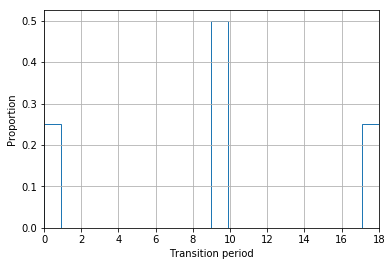

In [18]:
# Plot the distribution of transition period.
bins = np.arange(0, add_start_date_df['period'].max() + 1.5) - 0.5
fig = add_start_date_df.hist(column = 'period', histtype='step', bins = 20, 
                             weights=np.zeros_like(add_start_date_df['period'])+1./len(add_start_date_df['period']))
plt.xlim(xmin=0)
plt.xlim(xmax=add_start_date_df['period'].max())
plt.xlabel("Transition period")
plt.ylabel("Proportion")
plt.title("")
plt.show()

## 3. Permute the node labels of the original network to create a randomised network.

In [20]:
# Read a table that contains team membership data.
team_info = spark.read.parquet("s3://jinny-capstone-data-test/team_data.parquet")
team_info.registerTempTable("team_ids")

In [11]:
# Generate a mapping table.
mapping_tab_1 = pubg.permute_node_labels(td, players, team_info)

# Store it into the S3 bucket.
mapping_tab_1.write.parquet("s3://jinny-capstone-data-test/mapping-tables/map_tab_1.parquet")

In [30]:
# Read the mapping table.
map_tab = spark.read.parquet("s3://jinny-capstone-data-test/mapping-tables/map_tab_1.parquet")
map_tab.registerTempTable("map_tab")

In [40]:
# Get randomised gameplay logs.
temp_rand_logs = spark.sql("""SELECT mid, src, randomised AS new_src, dst, time, m_date 
                              FROM td t JOIN map_tab m ON t.src = m.original AND t.mid = m.match_id""")
temp_rand_logs.registerTempTable("temp_rand_logs")
randomised_logs = spark.sql("""SELECT mid, new_src AS src, randomised AS dst, time, m_date 
                               FROM temp_rand_logs t JOIN map_tab m 
                               ON t.dst = m.original AND t.mid = m.match_id""")
randomised_logs.registerTempTable("randomised_logs")

## 4. Count the motifs on the randomised networks.

In [52]:
# Add the cheating flags of players.
add_flags = spark.sql("""SELECT mid, src, ban_date AS src_bd, cheating_flag AS src_flag, 
                         dst, time, m_date 
                         FROM randomised_logs r JOIN nodes n ON r.src = n.id""")
add_flags.registerTempTable("add_flags")
randomised_logs = spark.sql("""SELECT mid, src, src_bd, src_flag, 
                               dst, ban_date AS dst_bd, cheating_flag AS dst_flag, time, m_date 
                               FROM add_flags r JOIN nodes n ON r.dst = n.id""")
randomised_logs.show(5)
randomised_logs.registerTempTable("td")

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|fcaf8c76-4e7a-4b9...|account.a0bc68e5e...|    NA|       0|account.001017dce...|    NA|       0|2019-03-02 06:56:...|2019-03-02|
|297788d0-ef37-4ab...|account.c419eaa2e...|    NA|       0|account.001017dce...|    NA|       0|2019-03-02 07:29:...|2019-03-02|
|d7b4a476-007b-4e7...|account.ff01e3c0d...|    NA|       0|account.0017aeb1b...|    NA|       0|2019-03-01 08:35:...|2019-03-01|
|03844fe8-6df5-4cd...|account.79aece347...|    NA|       0|account.00399d4c2...|    NA|       0|2019-03-01 04:24:...|2019-03-01|
|d8324042-12e1-401...|account.e2d270189...|    NA|       0|account.00399d4c2...|    NA|       0|2

In [50]:
# Download an excel file that contains randomised logs of the given sample match ID.
# temp_rand_logs = spark.sql("SELECT * FROM td WHERE mid = '000213be-6b3b-438a-8d20-c1b57b01a174'")
# temp_rand_logs_df = temp_rand_logs.toPandas()
# temp_rand_logs_df.to_csv('sample_rand_logs_1.csv')

In [53]:
rand_logs = pubg.add_level_of_harm(randomised_logs, 30)
rand_logs.registerTempTable("new_rand_td")
rand_logs.show(5)

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|0000d4aa-07fb-4b3...|account.05dd3a28f...|    NA|       0|account.cd31e8ad9...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.1866a3c61...|    NA|       0|account.09a6fd9cc...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.528ab8eb6...|    NA|       0|account.95d3d342f...|    NA|       0|2019-03-03 15:57:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.95d3d342f...|    NA|       0|account.6541e80e8...|    NA|       0|2019-03-03 15:56:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.95d3d342f...|    N

In [54]:
# First, add information of killers.
src_info = spark.sql("""SELECT mid, src, start_date AS src_sd, src_bd, src_flag, 
                        dst, dst_bd, dst_flag, time, m_date, damage 
                        FROM new_rand_td t JOIN nodes n ON t.src = n.id""")
src_info.registerTempTable("src_info")

# Add information of victims.
full_info = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag, 
                         dst, start_date AS dst_sd, dst_bd, dst_flag, time, m_date, damage 
                         FROM src_info s JOIN nodes n ON s.dst = n.id""")
full_info.registerTempTable("full_info")

+--------------------+--------------------+------+------+--------+--------------------+------+------+--------+--------------------+----------+------+
|                 mid|                 src|src_sd|src_bd|src_flag|                 dst|dst_sd|dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+------+------+--------+--------------------+------+------+--------+--------------------+----------+------+
|297788d0-ef37-4ab...|account.c419eaa2e...|    NA|    NA|       0|account.001017dce...|    NA|    NA|       0|2019-03-02 07:29:...|2019-03-02|     0|
|fcaf8c76-4e7a-4b9...|account.a0bc68e5e...|    NA|    NA|       0|account.001017dce...|    NA|    NA|       0|2019-03-02 06:56:...|2019-03-02|     0|
|d7b4a476-007b-4e7...|account.ff01e3c0d...|    NA|    NA|       0|account.0017aeb1b...|    NA|    NA|       0|2019-03-01 08:35:...|2019-03-01|     0|
|03844fe8-6df5-4cd...|account.79aece347...|    NA|    NA|       0|account.00399d4c2...|    NA|    NA

In [55]:
legit_cases = spark.sql("SELECT * FROM full_info WHERE dst_sd != 'NA' AND src_flag == 1 AND dst_flag == 1 AND m_date >= src_sd AND m_date < dst_sd")
legit_cases.registerTempTable("legit_cases")
legit_cases.show(20) 

+--------------------+--------------------+----------+----------+--------+--------------------+----------+----------+--------+--------------------+----------+------+
|                 mid|                 src|    src_sd|    src_bd|src_flag|                 dst|    dst_sd|    dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+----------+----------+--------+--------------------+----------+----------+--------+--------------------+----------+------+
|b7f8f82b-a249-43a...|account.568c81024...|2019-03-01|2019-03-02|       1|account.e493e8036...|2019-03-02|2019-03-03|       1|2019-03-01 19:50:...|2019-03-01|     0|
|d618a666-95ef-48c...|account.8ec434ba5...|2019-03-01|2019-03-02|       1|account.e493e8036...|2019-03-02|2019-03-03|       1|2019-03-01 20:03:...|2019-03-01|     0|
|407d731f-2e4e-4e7...|account.dddcd0225...|2019-03-01|2019-03-02|       1|account.53db3bd71...|2019-03-02|2019-03-02|       1|2019-03-01 23:58:...|2019-03-01|     0|
|a4f

In [56]:
# Create a summary table.
victims_tab = spark.sql("""SELECT dst AS id, 
                           TO_DATE(CAST(UNIX_TIMESTAMP(dst_sd, 'yyyy-MM-dd') AS TIMESTAMP)) AS start_date, 
                           TO_DATE(CAST(UNIX_TIMESTAMP(m_date, 'yyyy-MM-dd') AS TIMESTAMP)) AS m_date, 
                           CAST(DATEDIFF(dst_sd, m_date) AS INT) AS period, src AS killer, 
                           COUNT(*) AS exp, SUM(damage) AS sev_exp FROM legit_cases
                           GROUP BY dst, dst_sd, m_date, src""")
victims_tab.registerTempTable("victims_tab")
victims_tab.show()

# Get the date when the player was first killed by cheating.
first_m_dates = spark.sql("""SELECT * 
                             FROM (SELECT id, m_date, period, ROW_NUMBER() OVER (PARTITION BY id ORDER BY m_date) 
                             AS rownumber FROM victims_tab) WHERE rownumber IN (1)""")
first_m_dates.registerTempTable("first_m_dates")

+--------------------+----------+----------+------+--------------------+---+-------+
|                  id|start_date|    m_date|period|              killer|exp|sev_exp|
+--------------------+----------+----------+------+--------------------+---+-------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|account.568c81024...|  1|      0|
|account.e493e8036...|2019-03-02|2019-03-01|     1|account.8ec434ba5...|  1|      0|
|account.53db3bd71...|2019-03-02|2019-03-01|     1|account.dddcd0225...|  1|      0|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|account.00a68dddf...|  1|      1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|account.1baf22d18...|  1|      0|
|account.272b33c63...|2019-03-02|2019-03-01|     1|account.178b7a53b...|  1|      0|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|account.caeaf4f68...|  1|      1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|account.cb2db1993...|  1|      0|
|account.6825517dd...|2019-03-02|2019-03-01|     1|account.292503

In [57]:
# Get the table that contains the total number of victimisation experiences and the number of unique cheaters.
vic_info = spark.sql("""SELECT id, start_date, SUM(exp) AS total_exp, SUM(sev_exp) AS total_sev_exp, 
                        COUNT(DISTINCT killer) AS uniq_killers 
                        FROM victims_tab GROUP BY id, start_date""")
vic_info.registerTempTable("vic_info")
vic_info.show(5)

+--------------------+----------+---------+-------------+------------+
|                  id|start_date|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+---------+-------------+------------+
|account.d2cb5110d...|2019-03-03|        1|            0|           1|
|account.d974dde55...|2019-03-02|        1|            0|           1|
|account.e493e8036...|2019-03-02|        2|            0|           2|
|account.52adde8ad...|2019-03-02|        1|            0|           1|
|account.6825517dd...|2019-03-02|        2|            0|           1|
+--------------------+----------+---------+-------------+------------+
only showing top 5 rows



In [58]:
add_dates = spark.sql("""SELECT v.id, v.start_date, f.m_date, f.period, 
                         v.total_exp, v.total_sev_exp, v.uniq_killers 
                         FROM vic_info v LEFT JOIN first_m_dates f ON v.id = f.id""")
add_dates.show()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.53db3bd71...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...|2019-03-02|2019-03-01|     1|        2|            0|           1|
|account.70eb95960...

## 5. Plot the distribution of test statistics.

In [ ]:
# Plot the distribution of test statistics without considering the level of harm.
num_of_motifs_emp = 224
test_stats = [202, 223, 205, 189]

pubg.plot_dist_of_test_stats(num_of_motifs_emp, test_stats)

In [ ]:
# Plot the distribution of test statistics considering the level of harm.
num_of_motifs_emp = 107
test_stats = [86, 84, 75, 87]

pubg.plot_dist_of_test_stats(num_of_motifs_emp, test_stats)